In [1]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [2]:
!pip install colorama

In [3]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot

from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

from tqdm import tqdm, tqdm_notebook
from colorama import Fore
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import time
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import xgboost as xgb
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

print("All modules have been imported")

All modules have been imported


In [4]:
!apt-get install tree
clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

.
├── drive
│   └── MyDrive
│       ├── Colab Notebooks
│       ├── project2020
│       │   └── archive
│       │       ├── Br35H-Mask-RCNN
│       │       │   ├── TEST
│       │       │   ├── TRAIN
│       │       │   └── VAL
│       │       ├── LR
│       │       ├── main
│       │       │   ├── no
│       │       │   └── yes
│       │       ├── models
│       │       └── pred
│       └── saved model
├── sample_data
├── TEST
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
└── VAL
    ├── NO
    └── YES

26 directories


In [5]:
IMG_PATH = "/content/drive/MyDrive/project2020/archive/main"
# split the data by train/val/test
ignored = {"pred"}
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if CLASS not in ignored:
        if not CLASS.startswith('.'):
            IMG_NUM = len(os.listdir(IMG_PATH +"/"+ CLASS))
            for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH +"/"+ CLASS)):
                img = IMG_PATH+ '/' +  CLASS + '/' + FILE_NAME
                if n < 300:
                    shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
                elif n < 0.8*IMG_NUM:
                    shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
                else:
                    shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [6]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [7]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

In [8]:
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:03<00:00,  1.73s/it]
<ipython-input-6-b4599457589b>:18: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



1800 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


600 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]

600 images loaded from VAL/ directory.


In [9]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [10]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

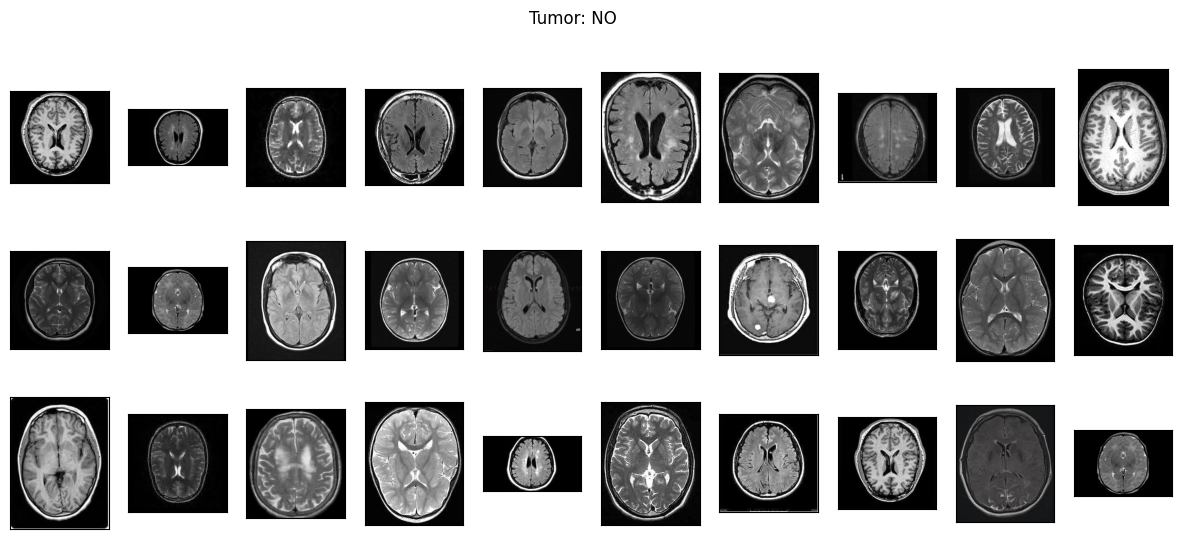

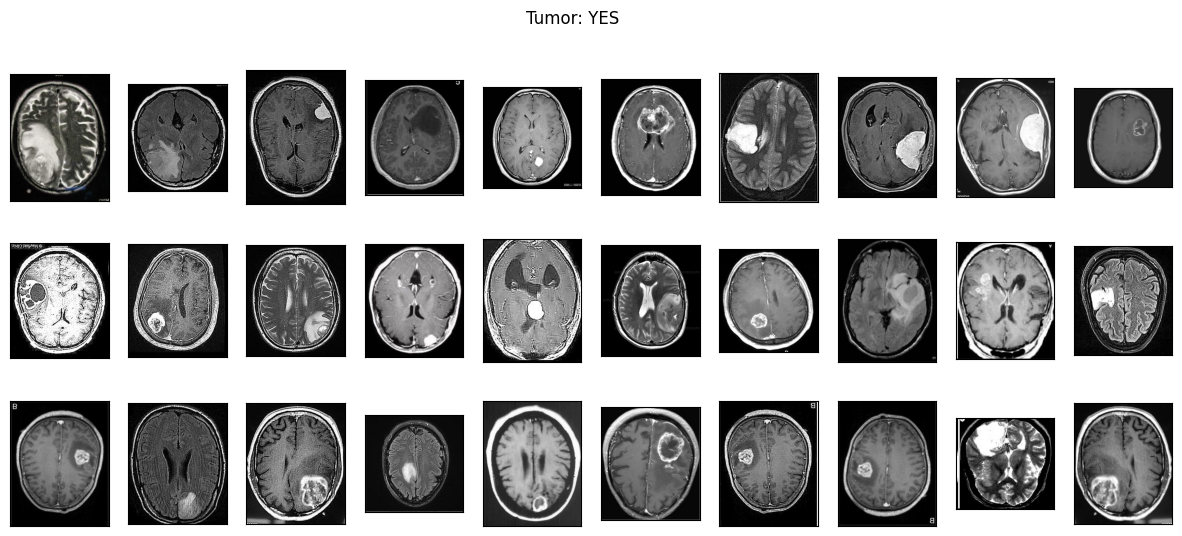

In [11]:
plot_samples(X_train, y_train, labels, 30)

In [12]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [13]:
import imutils
img = cv2.imread('/content/drive/MyDrive/project2020/archive/main/no/No17.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

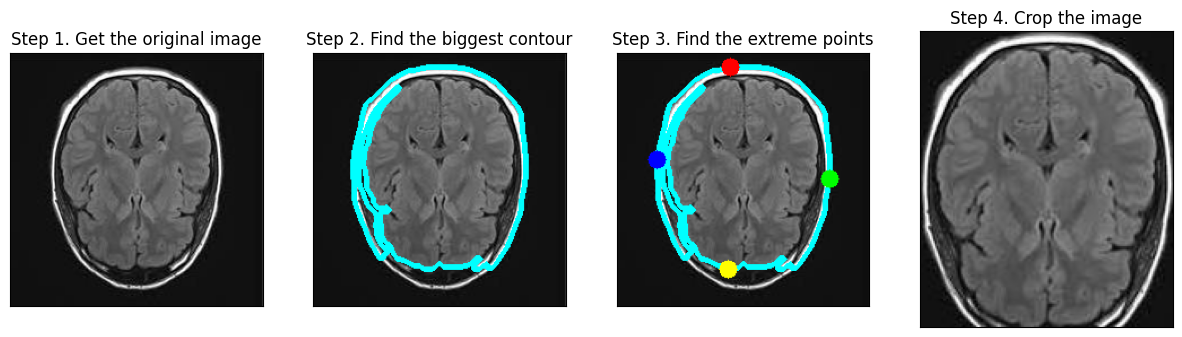

In [14]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [15]:
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

<ipython-input-12-65876982ba26>:31: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [16]:
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

<ipython-input-12-65876982ba26>:31: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [17]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [18]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

In [19]:
def preprocess_imgs(set_name, img_size):
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [20]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

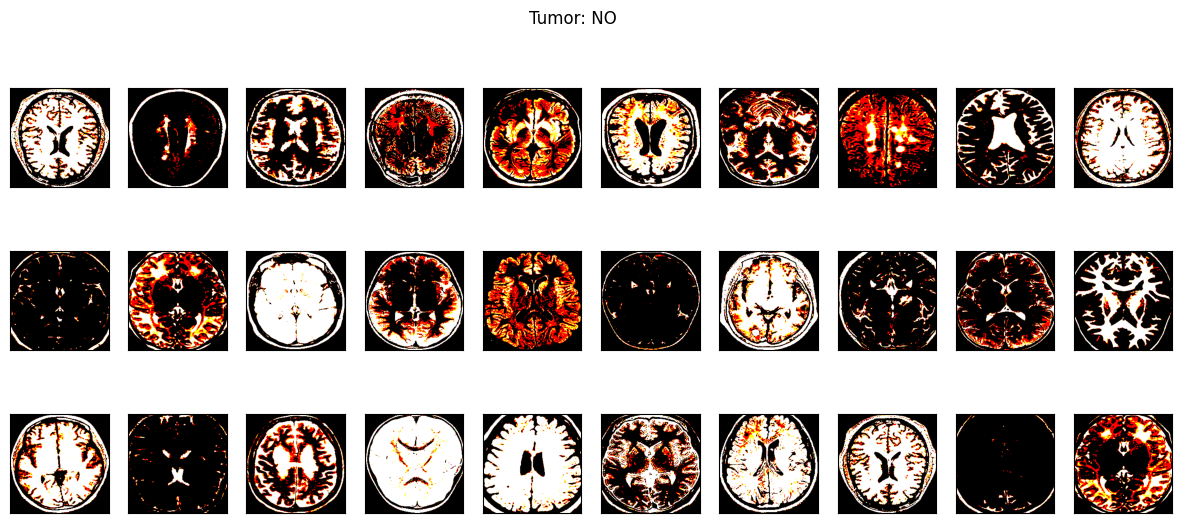

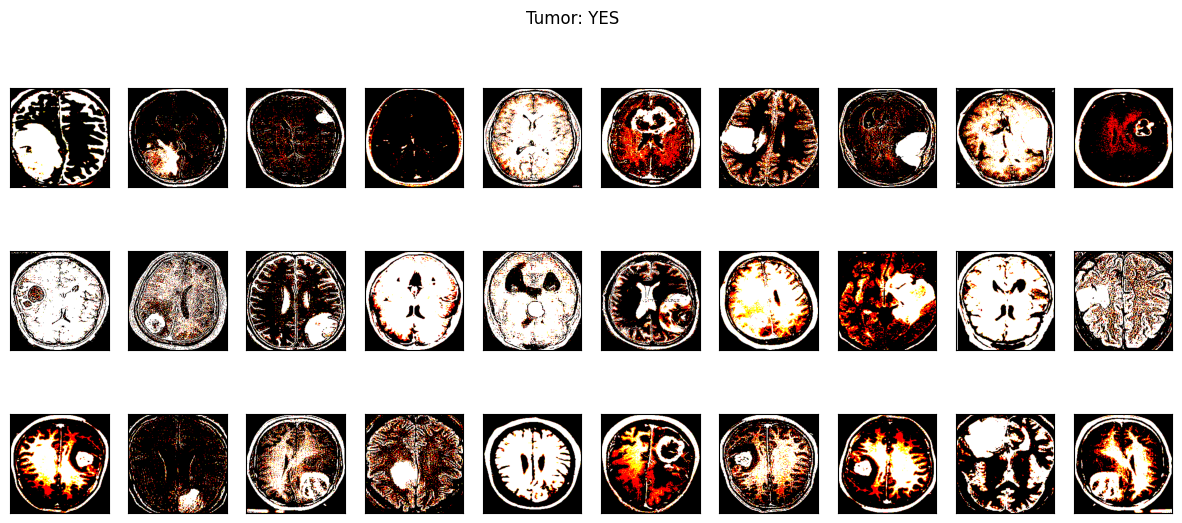

In [21]:
plot_samples(X_train_prep, y_train, labels, 30)

In [22]:
!pip install opencv-contrib-python

In [23]:
os.makedirs('preview', exist_ok=True)

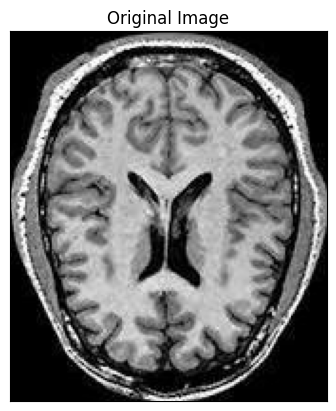

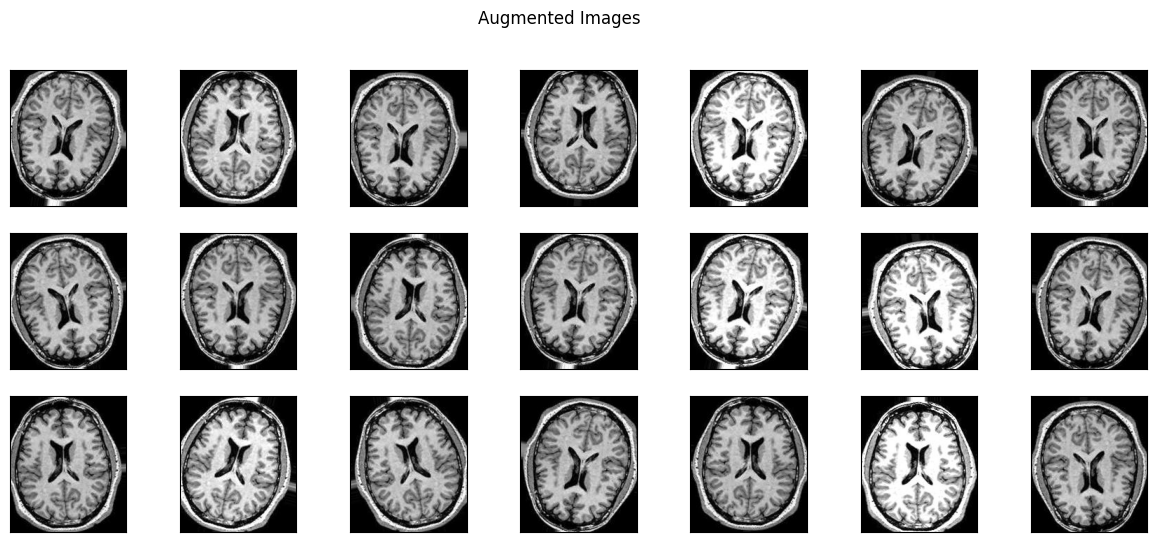

In [24]:
import os

demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

# Create the 'preview' directory if it doesn't exist
os.makedirs('preview', exist_ok=True)

x = X_train_crop[0]
x = x.reshape((1,) + x.shape)

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break

plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augmented Images')
plt.show()

In [25]:
!rm -rf preview/

In [26]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'
RANDOM_SEED = 42
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 1800 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [27]:
base_Neural_Net= ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

for layer in base_Neural_Net.layers:
    layer.trainable = False


model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy' , 'AUC']
)

model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 batch_normalization (BatchN  (None, 100352)           401408    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                         

In [28]:
EPOCHS = 100
es = EarlyStopping(
    monitor='val_acc',
    mode='max',
    patience=6
)
history = model.fit(
    train_generator,
    steps_per_epoch=30,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

Epoch 1/100
30/30 [==============================] - ETA: 0s - loss: 0.6681 - accuracy: 0.7969 - auc: 0.8716

30/30 [==============================] - 52s 1s/step - loss: 0.6681 - accuracy: 0.7969 - auc: 0.8716 - val_loss: 4.9645 - val_accuracy: 0.5775 - val_auc: 0.6921
Epoch 2/100
30/30 [==============================] - ETA: 0s - loss: 0.2701 - accuracy: 0.9071 - auc: 0.9580

30/30 [==============================] - 21s 686ms/step - loss: 0.2701 - accuracy: 0.9071 - auc: 0.9580 - val_loss: 1.0406 - val_accuracy: 0.7775 - val_auc: 0.9221
Epoch 3/100
30/30 [==============================] - ETA: 0s - loss: 0.1774 - accuracy: 0.9302 - auc: 0.9817

30/30 [==============================] - 21s 688ms/step - loss: 0.1774 - accuracy: 0.9302 - auc: 0.9817 - val_loss: 0.3482 - val_accuracy: 0.8875 - val_auc: 0.9799
Epoch 4/100
30/30 [==============================] - ETA: 0s - loss: 0.1866 - accuracy: 0.9359 - auc: 0.9778

30/30 [==============================] - 22s 735ms/step - loss: 0.1866 - accuracy: 0.9359 - auc: 0.9778 - val_loss: 0.2182 - val_accuracy: 0.9175 - val_auc: 0.9841
Epoch 5/100
30/30 [==============================] - ETA: 0s - loss: 0.1520 - accuracy: 0.9458 - auc: 0.9864

30/30 [==============================] - 23s 753ms/step - loss: 0.1520 - accuracy: 0.9458 - auc: 0.9864 - val_loss: 0.1928 - val_accuracy: 0.9425 - val_auc: 0.9886
Epoch 6/100
30/30 [==============================] - ETA: 0s - loss: 0.1307 - accuracy: 0.9479 - auc: 0.9899

30/30 [==============================] - 21s 696ms/step - loss: 0.1307 - accuracy: 0.9479 - auc: 0.9899 - val_loss: 0.1341 - val_accuracy: 0.9600 - val_auc: 0.9904
Epoch 7/100
30/30 [==============================] - ETA: 0s - loss: 0.1189 - accuracy: 0.9562 - auc: 0.9916

30/30 [==============================] - 22s 729ms/step - loss: 0.1189 - accuracy: 0.9562 - auc: 0.9916 - val_loss: 0.1227 - val_accuracy: 0.9650 - val_auc: 0.9925
Epoch 8/100
30/30 [==============================] - ETA: 0s - loss: 0.1120 - accuracy: 0.9594 - auc: 0.9928

30/30 [==============================] - 22s 735ms/step - loss: 0.1120 - accuracy: 0.9594 - auc: 0.9928 - val_loss: 0.1061 - val_accuracy: 0.9675 - val_auc: 0.9934
Epoch 9/100
30/30 [==============================] - ETA: 0s - loss: 0.0883 - accuracy: 0.9708 - auc: 0.9954

30/30 [==============================] - 20s 676ms/step - loss: 0.0883 - accuracy: 0.9708 - auc: 0.9954 - val_loss: 0.1019 - val_accuracy: 0.9700 - val_auc: 0.9939
Epoch 10/100
30/30 [==============================] - ETA: 0s - loss: 0.1052 - accuracy: 0.9625 - auc: 0.9936

30/30 [==============================] - 22s 730ms/step - loss: 0.1052 - accuracy: 0.9625 - auc: 0.9936 - val_loss: 0.0868 - val_accuracy: 0.9750 - val_auc: 0.9944
Epoch 11/100
30/30 [==============================] - ETA: 0s - loss: 0.0913 - accuracy: 0.9667 - auc: 0.9950

30/30 [==============================] - 22s 743ms/step - loss: 0.0913 - accuracy: 0.9667 - auc: 0.9950 - val_loss: 0.0892 - val_accuracy: 0.9675 - val_auc: 0.9957
Epoch 12/100
30/30 [==============================] - ETA: 0s - loss: 0.0935 - accuracy: 0.9562 - auc: 0.9953

30/30 [==============================] - 22s 710ms/step - loss: 0.0935 - accuracy: 0.9562 - auc: 0.9953 - val_loss: 0.0992 - val_accuracy: 0.9725 - val_auc: 0.9926
Epoch 13/100
30/30 [==============================] - ETA: 0s - loss: 0.0793 - accuracy: 0.9733 - auc: 0.9966

30/30 [==============================] - 20s 676ms/step - loss: 0.0793 - accuracy: 0.9733 - auc: 0.9966 - val_loss: 0.0840 - val_accuracy: 0.9750 - val_auc: 0.9934
Epoch 14/100
30/30 [==============================] - ETA: 0s - loss: 0.0827 - accuracy: 0.9635 - auc: 0.9957

30/30 [==============================] - 22s 744ms/step - loss: 0.0827 - accuracy: 0.9635 - auc: 0.9957 - val_loss: 0.0743 - val_accuracy: 0.9775 - val_auc: 0.9953
Epoch 15/100
30/30 [==============================] - ETA: 0s - loss: 0.0692 - accuracy: 0.9722 - auc: 0.9976

30/30 [==============================] - 21s 716ms/step - loss: 0.0692 - accuracy: 0.9722 - auc: 0.9976 - val_loss: 0.0766 - val_accuracy: 0.9775 - val_auc: 0.9925
Epoch 16/100
30/30 [==============================] - ETA: 0s - loss: 0.0562 - accuracy: 0.9750 - auc: 0.9986

30/30 [==============================] - 22s 738ms/step - loss: 0.0562 - accuracy: 0.9750 - auc: 0.9986 - val_loss: 0.0674 - val_accuracy: 0.9750 - val_auc: 0.9957
Epoch 17/100
30/30 [==============================] - ETA: 0s - loss: 0.0596 - accuracy: 0.9818 - auc: 0.9969

30/30 [==============================] - 24s 796ms/step - loss: 0.0596 - accuracy: 0.9818 - auc: 0.9969 - val_loss: 0.0883 - val_accuracy: 0.9750 - val_auc: 0.9918
Epoch 18/100
30/30 [==============================] - ETA: 0s - loss: 0.0589 - accuracy: 0.9840 - auc: 0.9979

30/30 [==============================] - 21s 718ms/step - loss: 0.0589 - accuracy: 0.9840 - auc: 0.9979 - val_loss: 0.0985 - val_accuracy: 0.9725 - val_auc: 0.9898
Epoch 19/100
30/30 [==============================] - ETA: 0s - loss: 0.0589 - accuracy: 0.9771 - auc: 0.9980

30/30 [==============================] - 22s 751ms/step - loss: 0.0589 - accuracy: 0.9771 - auc: 0.9980 - val_loss: 0.0854 - val_accuracy: 0.9700 - val_auc: 0.9954
Epoch 20/100
30/30 [==============================] - ETA: 0s - loss: 0.0627 - accuracy: 0.9786 - auc: 0.9975

30/30 [==============================] - 23s 760ms/step - loss: 0.0627 - accuracy: 0.9786 - auc: 0.9975 - val_loss: 0.0848 - val_accuracy: 0.9775 - val_auc: 0.9921
Epoch 21/100
30/30 [==============================] - ETA: 0s - loss: 0.0429 - accuracy: 0.9861 - auc: 0.9989

30/30 [==============================] - 22s 753ms/step - loss: 0.0429 - accuracy: 0.9861 - auc: 0.9989 - val_loss: 0.0886 - val_accuracy: 0.9700 - val_auc: 0.9955
Epoch 22/100
30/30 [==============================] - ETA: 0s - loss: 0.0495 - accuracy: 0.9854 - auc: 0.9988

30/30 [==============================] - 21s 686ms/step - loss: 0.0495 - accuracy: 0.9854 - auc: 0.9988 - val_loss: 0.0775 - val_accuracy: 0.9800 - val_auc: 0.9928
Epoch 23/100
30/30 [==============================] - ETA: 0s - loss: 0.0429 - accuracy: 0.9823 - auc: 0.9991

30/30 [==============================] - 24s 802ms/step - loss: 0.0429 - accuracy: 0.9823 - auc: 0.9991 - val_loss: 0.0754 - val_accuracy: 0.9700 - val_auc: 0.9975
Epoch 24/100
30/30 [==============================] - ETA: 0s - loss: 0.0383 - accuracy: 0.9896 - auc: 0.9992

30/30 [==============================] - 24s 789ms/step - loss: 0.0383 - accuracy: 0.9896 - auc: 0.9992 - val_loss: 0.0797 - val_accuracy: 0.9800 - val_auc: 0.9956
Epoch 25/100
30/30 [==============================] - ETA: 0s - loss: 0.0519 - accuracy: 0.9833 - auc: 0.9983

30/30 [==============================] - 22s 727ms/step - loss: 0.0519 - accuracy: 0.9833 - auc: 0.9983 - val_loss: 0.0556 - val_accuracy: 0.9800 - val_auc: 0.9983
Epoch 26/100
30/30 [==============================] - ETA: 0s - loss: 0.0569 - accuracy: 0.9792 - auc: 0.9980

30/30 [==============================] - 20s 678ms/step - loss: 0.0569 - accuracy: 0.9792 - auc: 0.9980 - val_loss: 0.0720 - val_accuracy: 0.9775 - val_auc: 0.9936
Epoch 27/100
30/30 [==============================] - ETA: 0s - loss: 0.0506 - accuracy: 0.9854 - auc: 0.9973

30/30 [==============================] - 23s 773ms/step - loss: 0.0506 - accuracy: 0.9854 - auc: 0.9973 - val_loss: 0.0560 - val_accuracy: 0.9800 - val_auc: 0.9967
Epoch 28/100
30/30 [==============================] - ETA: 0s - loss: 0.0407 - accuracy: 0.9875 - auc: 0.9990

30/30 [==============================] - 23s 779ms/step - loss: 0.0407 - accuracy: 0.9875 - auc: 0.9990 - val_loss: 0.0978 - val_accuracy: 0.9800 - val_auc: 0.9905
Epoch 29/100
30/30 [==============================] - ETA: 0s - loss: 0.0495 - accuracy: 0.9833 - auc: 0.9976

30/30 [==============================] - 20s 671ms/step - loss: 0.0495 - accuracy: 0.9833 - auc: 0.9976 - val_loss: 0.0939 - val_accuracy: 0.9825 - val_auc: 0.9931
Epoch 30/100
30/30 [==============================] - ETA: 0s - loss: 0.0328 - accuracy: 0.9872 - auc: 0.9994

30/30 [==============================] - 23s 758ms/step - loss: 0.0328 - accuracy: 0.9872 - auc: 0.9994 - val_loss: 0.0704 - val_accuracy: 0.9825 - val_auc: 0.9956
Epoch 31/100
30/30 [==============================] - ETA: 0s - loss: 0.0300 - accuracy: 0.9896 - auc: 0.9997

30/30 [==============================] - 24s 791ms/step - loss: 0.0300 - accuracy: 0.9896 - auc: 0.9997 - val_loss: 0.1024 - val_accuracy: 0.9775 - val_auc: 0.9913
Epoch 32/100
30/30 [==============================] - ETA: 0s - loss: 0.0236 - accuracy: 0.9936 - auc: 0.9996

30/30 [==============================] - 21s 701ms/step - loss: 0.0236 - accuracy: 0.9936 - auc: 0.9996 - val_loss: 0.0921 - val_accuracy: 0.9825 - val_auc: 0.9910
Epoch 33/100
30/30 [==============================] - ETA: 0s - loss: 0.0271 - accuracy: 0.9885 - auc: 0.9996

30/30 [==============================] - 20s 671ms/step - loss: 0.0271 - accuracy: 0.9885 - auc: 0.9996 - val_loss: 0.0806 - val_accuracy: 0.9825 - val_auc: 0.9934
Epoch 34/100
30/30 [==============================] - ETA: 0s - loss: 0.0464 - accuracy: 0.9840 - auc: 0.9985

30/30 [==============================] - 23s 758ms/step - loss: 0.0464 - accuracy: 0.9840 - auc: 0.9985 - val_loss: 0.0769 - val_accuracy: 0.9775 - val_auc: 0.9935
Epoch 35/100
30/30 [==============================] - ETA: 0s - loss: 0.0325 - accuracy: 0.9896 - auc: 0.9994

30/30 [==============================] - 21s 690ms/step - loss: 0.0325 - accuracy: 0.9896 - auc: 0.9994 - val_loss: 0.0736 - val_accuracy: 0.9825 - val_auc: 0.9962
Epoch 36/100
30/30 [==============================] - ETA: 0s - loss: 0.0413 - accuracy: 0.9882 - auc: 0.9979

30/30 [==============================] - 20s 655ms/step - loss: 0.0413 - accuracy: 0.9882 - auc: 0.9979 - val_loss: 0.0733 - val_accuracy: 0.9775 - val_auc: 0.9957
Epoch 37/100
30/30 [==============================] - ETA: 0s - loss: 0.0517 - accuracy: 0.9850 - auc: 0.9976

30/30 [==============================] - 25s 856ms/step - loss: 0.0517 - accuracy: 0.9850 - auc: 0.9976 - val_loss: 0.0310 - val_accuracy: 0.9900 - val_auc: 0.9996
Epoch 38/100
30/30 [==============================] - ETA: 0s - loss: 0.0515 - accuracy: 0.9818 - auc: 0.9976

30/30 [==============================] - 23s 758ms/step - loss: 0.0515 - accuracy: 0.9818 - auc: 0.9976 - val_loss: 0.0835 - val_accuracy: 0.9800 - val_auc: 0.9930
Epoch 39/100
30/30 [==============================] - ETA: 0s - loss: 0.0434 - accuracy: 0.9844 - auc: 0.9980

30/30 [==============================] - 21s 688ms/step - loss: 0.0434 - accuracy: 0.9844 - auc: 0.9980 - val_loss: 0.0867 - val_accuracy: 0.9775 - val_auc: 0.9928
Epoch 40/100
30/30 [==============================] - ETA: 0s - loss: 0.0380 - accuracy: 0.9840 - auc: 0.9994

30/30 [==============================] - 20s 657ms/step - loss: 0.0380 - accuracy: 0.9840 - auc: 0.9994 - val_loss: 0.0999 - val_accuracy: 0.9775 - val_auc: 0.9917
Epoch 41/100
30/30 [==============================] - ETA: 0s - loss: 0.0386 - accuracy: 0.9854 - auc: 0.9992

30/30 [==============================] - 24s 819ms/step - loss: 0.0386 - accuracy: 0.9854 - auc: 0.9992 - val_loss: 0.0831 - val_accuracy: 0.9800 - val_auc: 0.9937
Epoch 42/100
30/30 [==============================] - ETA: 0s - loss: 0.0532 - accuracy: 0.9818 - auc: 0.9971

30/30 [==============================] - 23s 781ms/step - loss: 0.0532 - accuracy: 0.9818 - auc: 0.9971 - val_loss: 0.0779 - val_accuracy: 0.9775 - val_auc: 0.9947
Epoch 43/100
30/30 [==============================] - ETA: 0s - loss: 0.0317 - accuracy: 0.9893 - auc: 0.9996

30/30 [==============================] - 24s 791ms/step - loss: 0.0317 - accuracy: 0.9893 - auc: 0.9996 - val_loss: 0.0802 - val_accuracy: 0.9850 - val_auc: 0.9912
Epoch 44/100
30/30 [==============================] - ETA: 0s - loss: 0.0334 - accuracy: 0.9833 - auc: 0.9994

30/30 [==============================] - 36s 1s/step - loss: 0.0334 - accuracy: 0.9833 - auc: 0.9994 - val_loss: 0.0995 - val_accuracy: 0.9775 - val_auc: 0.9927
Epoch 45/100
30/30 [==============================] - ETA: 0s - loss: 0.0286 - accuracy: 0.9917 - auc: 0.9996

30/30 [==============================] - 20s 673ms/step - loss: 0.0286 - accuracy: 0.9917 - auc: 0.9996 - val_loss: 0.0604 - val_accuracy: 0.9900 - val_auc: 0.9966
Epoch 46/100
30/30 [==============================] - ETA: 0s - loss: 0.0242 - accuracy: 0.9915 - auc: 0.9998

30/30 [==============================] - 21s 717ms/step - loss: 0.0242 - accuracy: 0.9915 - auc: 0.9998 - val_loss: 0.1184 - val_accuracy: 0.9775 - val_auc: 0.9932
Epoch 47/100
30/30 [==============================] - ETA: 0s - loss: 0.0285 - accuracy: 0.9872 - auc: 0.9996

30/30 [==============================] - 23s 784ms/step - loss: 0.0285 - accuracy: 0.9872 - auc: 0.9996 - val_loss: 0.0826 - val_accuracy: 0.9825 - val_auc: 0.9959
Epoch 48/100
30/30 [==============================] - ETA: 0s - loss: 0.0281 - accuracy: 0.9915 - auc: 0.9994

30/30 [==============================] - 20s 678ms/step - loss: 0.0281 - accuracy: 0.9915 - auc: 0.9994 - val_loss: 0.0558 - val_accuracy: 0.9825 - val_auc: 0.9965
Epoch 49/100
30/30 [==============================] - ETA: 0s - loss: 0.0315 - accuracy: 0.9906 - auc: 0.9993

30/30 [==============================] - 22s 735ms/step - loss: 0.0315 - accuracy: 0.9906 - auc: 0.9993 - val_loss: 0.0668 - val_accuracy: 0.9875 - val_auc: 0.9961
Epoch 50/100
30/30 [==============================] - ETA: 0s - loss: 0.0222 - accuracy: 0.9947 - auc: 0.9996

30/30 [==============================] - 20s 667ms/step - loss: 0.0222 - accuracy: 0.9947 - auc: 0.9996 - val_loss: 0.0829 - val_accuracy: 0.9800 - val_auc: 0.9941
Epoch 51/100
30/30 [==============================] - ETA: 0s - loss: 0.0246 - accuracy: 0.9915 - auc: 0.9986

30/30 [==============================] - 23s 768ms/step - loss: 0.0246 - accuracy: 0.9915 - auc: 0.9986 - val_loss: 0.0931 - val_accuracy: 0.9800 - val_auc: 0.9934
Epoch 52/100
30/30 [==============================] - ETA: 0s - loss: 0.0362 - accuracy: 0.9872 - auc: 0.9992

30/30 [==============================] - ETA: 0s - loss: 0.0344 - accuracy: 0.9885 - auc: 0.9992

30/30 [==============================] - 24s 794ms/step - loss: 0.0344 - accuracy: 0.9885 - auc: 0.9992 - val_loss: 0.0891 - val_accuracy: 0.9825 - val_auc: 0.9940
Epoch 54/100
30/30 [==============================] - ETA: 0s - loss: 0.0333 - accuracy: 0.9893 - auc: 0.9993

30/30 [==============================] - 19s 648ms/step - loss: 0.0333 - accuracy: 0.9893 - auc: 0.9993 - val_loss: 0.0816 - val_accuracy: 0.9825 - val_auc: 0.9914
Epoch 55/100
30/30 [==============================] - ETA: 0s - loss: 0.0525 - accuracy: 0.9872 - auc: 0.9969

30/30 [==============================] - 25s 851ms/step - loss: 0.0525 - accuracy: 0.9872 - auc: 0.9969 - val_loss: 0.0997 - val_accuracy: 0.9825 - val_auc: 0.9879
Epoch 56/100
30/30 [==============================] - ETA: 0s - loss: 0.0447 - accuracy: 0.9844 - auc: 0.9979

30/30 [==============================] - 20s 684ms/step - loss: 0.0447 - accuracy: 0.9844 - auc: 0.9979 - val_loss: 0.0797 - val_accuracy: 0.9775 - val_auc: 0.9940
Epoch 57/100
30/30 [==============================] - ETA: 0s - loss: 0.0335 - accuracy: 0.9882 - auc: 0.9995

30/30 [==============================] - 20s 656ms/step - loss: 0.0335 - accuracy: 0.9882 - auc: 0.9995 - val_loss: 0.0437 - val_accuracy: 0.9875 - val_auc: 0.9968
Epoch 58/100
30/30 [==============================] - ETA: 0s - loss: 0.0378 - accuracy: 0.9854 - auc: 0.9992

30/30 [==============================] - 22s 724ms/step - loss: 0.0378 - accuracy: 0.9854 - auc: 0.9992 - val_loss: 0.0675 - val_accuracy: 0.9850 - val_auc: 0.9941
Epoch 59/100
30/30 [==============================] - ETA: 0s - loss: 0.0224 - accuracy: 0.9915 - auc: 0.9998

30/30 [==============================] - 20s 654ms/step - loss: 0.0224 - accuracy: 0.9915 - auc: 0.9998 - val_loss: 0.0607 - val_accuracy: 0.9900 - val_auc: 0.9944
Epoch 60/100
30/30 [==============================] - ETA: 0s - loss: 0.0358 - accuracy: 0.9872 - auc: 0.9990

30/30 [==============================] - 21s 718ms/step - loss: 0.0358 - accuracy: 0.9872 - auc: 0.9990 - val_loss: 0.0775 - val_accuracy: 0.9850 - val_auc: 0.9938
Epoch 61/100
30/30 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 0.9833 - auc: 0.9973

30/30 [==============================] - 20s 683ms/step - loss: 0.0491 - accuracy: 0.9833 - auc: 0.9973 - val_loss: 0.0858 - val_accuracy: 0.9825 - val_auc: 0.9938
Epoch 62/100
30/30 [==============================] - ETA: 0s - loss: 0.0286 - accuracy: 0.9896 - auc: 0.9995

30/30 [==============================] - 23s 787ms/step - loss: 0.0286 - accuracy: 0.9896 - auc: 0.9995 - val_loss: 0.0677 - val_accuracy: 0.9875 - val_auc: 0.9946
Epoch 63/100
30/30 [==============================] - ETA: 0s - loss: 0.0339 - accuracy: 0.9850 - auc: 0.9995

30/30 [==============================] - 20s 669ms/step - loss: 0.0339 - accuracy: 0.9850 - auc: 0.9995 - val_loss: 0.0565 - val_accuracy: 0.9900 - val_auc: 0.9946
Epoch 64/100
30/30 [==============================] - ETA: 0s - loss: 0.0365 - accuracy: 0.9854 - auc: 0.9992

30/30 [==============================] - 24s 801ms/step - loss: 0.0365 - accuracy: 0.9854 - auc: 0.9992 - val_loss: 0.0644 - val_accuracy: 0.9825 - val_auc: 0.9942
Epoch 65/100
30/30 [==============================] - ETA: 0s - loss: 0.0321 - accuracy: 0.9893 - auc: 0.9984

30/30 [==============================] - 25s 829ms/step - loss: 0.0321 - accuracy: 0.9893 - auc: 0.9984 - val_loss: 0.0932 - val_accuracy: 0.9825 - val_auc: 0.9913
Epoch 66/100
30/30 [==============================] - ETA: 0s - loss: 0.0406 - accuracy: 0.9875 - auc: 0.9983

30/30 [==============================] - 20s 680ms/step - loss: 0.0406 - accuracy: 0.9875 - auc: 0.9983 - val_loss: 0.0921 - val_accuracy: 0.9825 - val_auc: 0.9933
Epoch 67/100
30/30 [==============================] - ETA: 0s - loss: 0.0231 - accuracy: 0.9917 - auc: 0.9996

30/30 [==============================] - 21s 704ms/step - loss: 0.0231 - accuracy: 0.9917 - auc: 0.9996 - val_loss: 0.0638 - val_accuracy: 0.9825 - val_auc: 0.9964
Epoch 68/100
30/30 [==============================] - ETA: 0s - loss: 0.0305 - accuracy: 0.9896 - auc: 0.9994

30/30 [==============================] - 20s 672ms/step - loss: 0.0305 - accuracy: 0.9896 - auc: 0.9994 - val_loss: 0.0576 - val_accuracy: 0.9900 - val_auc: 0.9969
Epoch 69/100
30/30 [==============================] - ETA: 0s - loss: 0.0220 - accuracy: 0.9927 - auc: 0.9998

30/30 [==============================] - 22s 747ms/step - loss: 0.0220 - accuracy: 0.9927 - auc: 0.9998 - val_loss: 0.0506 - val_accuracy: 0.9900 - val_auc: 0.9970
Epoch 70/100
30/30 [==============================] - ETA: 0s - loss: 0.0214 - accuracy: 0.9958 - auc: 0.9997

30/30 [==============================] - 21s 688ms/step - loss: 0.0214 - accuracy: 0.9958 - auc: 0.9997 - val_loss: 0.0210 - val_accuracy: 0.9900 - val_auc: 0.9999
Epoch 71/100
30/30 [==============================] - ETA: 0s - loss: 0.0403 - accuracy: 0.9875 - auc: 0.9988

30/30 [==============================] - 22s 735ms/step - loss: 0.0403 - accuracy: 0.9875 - auc: 0.9988 - val_loss: 0.0735 - val_accuracy: 0.9850 - val_auc: 0.9942
Epoch 72/100
30/30 [==============================] - ETA: 0s - loss: 0.0476 - accuracy: 0.9854 - auc: 0.9977

30/30 [==============================] - 22s 730ms/step - loss: 0.0476 - accuracy: 0.9854 - auc: 0.9977 - val_loss: 0.1080 - val_accuracy: 0.9725 - val_auc: 0.9910
Epoch 73/100
30/30 [==============================] - ETA: 0s - loss: 0.0282 - accuracy: 0.9893 - auc: 0.9995

30/30 [==============================] - 24s 808ms/step - loss: 0.0282 - accuracy: 0.9893 - auc: 0.9995 - val_loss: 0.0315 - val_accuracy: 0.9925 - val_auc: 0.9973
Epoch 74/100
30/30 [==============================] - ETA: 0s - loss: 0.0428 - accuracy: 0.9854 - auc: 0.9988

30/30 [==============================] - 25s 838ms/step - loss: 0.0428 - accuracy: 0.9854 - auc: 0.9988 - val_loss: 0.0884 - val_accuracy: 0.9825 - val_auc: 0.9941
Epoch 75/100
30/30 [==============================] - ETA: 0s - loss: 0.0364 - accuracy: 0.9885 - auc: 0.9983

30/30 [==============================] - 20s 668ms/step - loss: 0.0364 - accuracy: 0.9885 - auc: 0.9983 - val_loss: 0.0999 - val_accuracy: 0.9825 - val_auc: 0.9937
Epoch 76/100
30/30 [==============================] - ETA: 0s - loss: 0.0338 - accuracy: 0.9885 - auc: 0.9994

30/30 [==============================] - 22s 710ms/step - loss: 0.0338 - accuracy: 0.9885 - auc: 0.9994 - val_loss: 0.0902 - val_accuracy: 0.9825 - val_auc: 0.9942
Epoch 77/100
30/30 [==============================] - ETA: 0s - loss: 0.0239 - accuracy: 0.9917 - auc: 0.9996

30/30 [==============================] - 20s 687ms/step - loss: 0.0239 - accuracy: 0.9917 - auc: 0.9996 - val_loss: 0.0886 - val_accuracy: 0.9775 - val_auc: 0.9939
Epoch 78/100
30/30 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 0.9927 - auc: 0.9995

30/30 [==============================] - 21s 688ms/step - loss: 0.0245 - accuracy: 0.9927 - auc: 0.9995 - val_loss: 0.0762 - val_accuracy: 0.9850 - val_auc: 0.9942
Epoch 79/100
30/30 [==============================] - ETA: 0s - loss: 0.0352 - accuracy: 0.9861 - auc: 0.9993

30/30 [==============================] - 23s 760ms/step - loss: 0.0352 - accuracy: 0.9861 - auc: 0.9993 - val_loss: 0.1142 - val_accuracy: 0.9725 - val_auc: 0.9942
Epoch 80/100
30/30 [==============================] - ETA: 0s - loss: 0.0643 - accuracy: 0.9786 - auc: 0.9965

30/30 [==============================] - 23s 757ms/step - loss: 0.0643 - accuracy: 0.9786 - auc: 0.9965 - val_loss: 0.0558 - val_accuracy: 0.9875 - val_auc: 0.9971
Epoch 81/100
30/30 [==============================] - ETA: 0s - loss: 0.0440 - accuracy: 0.9893 - auc: 0.9980

30/30 [==============================] - 20s 669ms/step - loss: 0.0440 - accuracy: 0.9893 - auc: 0.9980 - val_loss: 0.0885 - val_accuracy: 0.9775 - val_auc: 0.9963
Epoch 82/100
30/30 [==============================] - ETA: 0s - loss: 0.0681 - accuracy: 0.9754 - auc: 0.9964

30/30 [==============================] - 23s 766ms/step - loss: 0.0681 - accuracy: 0.9754 - auc: 0.9964 - val_loss: 0.0488 - val_accuracy: 0.9825 - val_auc: 0.9971
Epoch 83/100
30/30 [==============================] - ETA: 0s - loss: 0.0547 - accuracy: 0.9829 - auc: 0.9974

30/30 [==============================] - 23s 765ms/step - loss: 0.0547 - accuracy: 0.9829 - auc: 0.9974 - val_loss: 0.0340 - val_accuracy: 0.9875 - val_auc: 0.9995
Epoch 84/100
30/30 [==============================] - ETA: 0s - loss: 0.0286 - accuracy: 0.9872 - auc: 0.9996

30/30 [==============================] - 23s 766ms/step - loss: 0.0286 - accuracy: 0.9872 - auc: 0.9996 - val_loss: 0.0831 - val_accuracy: 0.9850 - val_auc: 0.9935
Epoch 85/100
30/30 [==============================] - ETA: 0s - loss: 0.0263 - accuracy: 0.9865 - auc: 0.9997

30/30 [==============================] - 23s 781ms/step - loss: 0.0263 - accuracy: 0.9865 - auc: 0.9997 - val_loss: 0.0173 - val_accuracy: 0.9900 - val_auc: 0.9999
Epoch 86/100
30/30 [==============================] - ETA: 0s - loss: 0.0283 - accuracy: 0.9893 - auc: 0.9995

30/30 [==============================] - 23s 763ms/step - loss: 0.0283 - accuracy: 0.9893 - auc: 0.9995 - val_loss: 0.0780 - val_accuracy: 0.9900 - val_auc: 0.9947
Epoch 87/100
30/30 [==============================] - ETA: 0s - loss: 0.0217 - accuracy: 0.9917 - auc: 0.9998

30/30 [==============================] - 23s 786ms/step - loss: 0.0217 - accuracy: 0.9917 - auc: 0.9998 - val_loss: 0.0886 - val_accuracy: 0.9850 - val_auc: 0.9947
Epoch 88/100
30/30 [==============================] - ETA: 0s - loss: 0.0205 - accuracy: 0.9948 - auc: 0.9999

30/30 [==============================] - 22s 727ms/step - loss: 0.0205 - accuracy: 0.9948 - auc: 0.9999 - val_loss: 0.0343 - val_accuracy: 0.9875 - val_auc: 0.9972
Epoch 89/100
30/30 [==============================] - ETA: 0s - loss: 0.0287 - accuracy: 0.9896 - auc: 0.9995

30/30 [==============================] - 23s 776ms/step - loss: 0.0287 - accuracy: 0.9896 - auc: 0.9995 - val_loss: 0.0719 - val_accuracy: 0.9850 - val_auc: 0.9943
Epoch 90/100
30/30 [==============================] - ETA: 0s - loss: 0.0312 - accuracy: 0.9875 - auc: 0.9985

30/30 [==============================] - 20s 681ms/step - loss: 0.0312 - accuracy: 0.9875 - auc: 0.9985 - val_loss: 0.1045 - val_accuracy: 0.9850 - val_auc: 0.9936
Epoch 91/100
30/30 [==============================] - ETA: 0s - loss: 0.0204 - accuracy: 0.9937 - auc: 0.9997

30/30 [==============================] - 24s 792ms/step - loss: 0.0204 - accuracy: 0.9937 - auc: 0.9997 - val_loss: 0.1046 - val_accuracy: 0.9850 - val_auc: 0.9917
Epoch 92/100
30/30 [==============================] - ETA: 0s - loss: 0.0248 - accuracy: 0.9885 - auc: 0.9997

30/30 [==============================] - 20s 675ms/step - loss: 0.0248 - accuracy: 0.9885 - auc: 0.9997 - val_loss: 0.0724 - val_accuracy: 0.9850 - val_auc: 0.9972
Epoch 93/100
30/30 [==============================] - ETA: 0s - loss: 0.0279 - accuracy: 0.9906 - auc: 0.9995

30/30 [==============================] - 22s 730ms/step - loss: 0.0279 - accuracy: 0.9906 - auc: 0.9995 - val_loss: 0.1195 - val_accuracy: 0.9800 - val_auc: 0.9918
Epoch 94/100
30/30 [==============================] - ETA: 0s - loss: 0.0258 - accuracy: 0.9872 - auc: 0.9996

30/30 [==============================] - 20s 655ms/step - loss: 0.0258 - accuracy: 0.9872 - auc: 0.9996 - val_loss: 0.0814 - val_accuracy: 0.9900 - val_auc: 0.9943
Epoch 95/100
30/30 [==============================] - ETA: 0s - loss: 0.0223 - accuracy: 0.9917 - auc: 0.9998

30/30 [==============================] - 23s 769ms/step - loss: 0.0223 - accuracy: 0.9917 - auc: 0.9998 - val_loss: 0.1202 - val_accuracy: 0.9775 - val_auc: 0.9921
Epoch 96/100
30/30 [==============================] - ETA: 0s - loss: 0.0256 - accuracy: 0.9927 - auc: 0.9997

30/30 [==============================] - 23s 781ms/step - loss: 0.0256 - accuracy: 0.9927 - auc: 0.9997 - val_loss: 0.0760 - val_accuracy: 0.9925 - val_auc: 0.9948
Epoch 97/100
30/30 [==============================] - ETA: 0s - loss: 0.0183 - accuracy: 0.9948 - auc: 0.9997

30/30 [==============================] - 23s 773ms/step - loss: 0.0183 - accuracy: 0.9948 - auc: 0.9997 - val_loss: 0.1097 - val_accuracy: 0.9850 - val_auc: 0.9912
Epoch 98/100
30/30 [==============================] - ETA: 0s - loss: 0.0235 - accuracy: 0.9885 - auc: 0.9998

30/30 [==============================] - 22s 747ms/step - loss: 0.0235 - accuracy: 0.9885 - auc: 0.9998 - val_loss: 0.0983 - val_accuracy: 0.9825 - val_auc: 0.9941
Epoch 99/100
30/30 [==============================] - ETA: 0s - loss: 0.0145 - accuracy: 0.9947 - auc: 0.9999

30/30 [==============================] - 20s 671ms/step - loss: 0.0145 - accuracy: 0.9947 - auc: 0.9999 - val_loss: 0.0793 - val_accuracy: 0.9900 - val_auc: 0.9950
Epoch 100/100
30/30 [==============================] - ETA: 0s - loss: 0.0210 - accuracy: 0.9915 - auc: 0.9998

30/30 [==============================] - 22s 723ms/step - loss: 0.0210 - accuracy: 0.9915 - auc: 0.9998 - val_loss: 0.0262 - val_accuracy: 0.9900 - val_auc: 0.9999


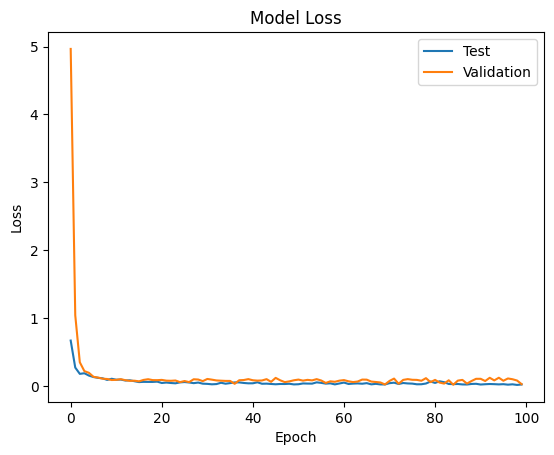

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test', 'Validation'], loc='upper right')
plt.show()

57/57 [==============================] - 7s 100ms/step
Train Accuracy = 1.00


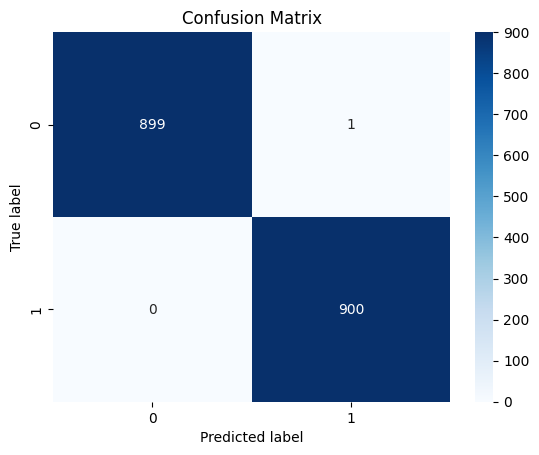

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have defined and trained a model named 'model'

# Calculate predictions
predictions = model.predict(X_train_prep)
predictions = [1 if x > 0.5 else 0 for x in predictions]

# Calculate accuracy
accuracy = accuracy_score(y_train, predictions)
print('Train Accuracy = %.2f' % accuracy)

# Compute confusion matrix
confusion_mtx = confusion_matrix(y_train, predictions)

# Plot confusion matrix using seaborn
sns.heatmap(confusion_mtx, annot=True, cmap='Blues', fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

In [31]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    # Other code...

    # Calculate threshold value based on the maximum value in the confusion matrix
    thresh = cm.max() / 2.0

    # Other code...

19/19 [==============================] - 2s 103ms/step
Val Accuracy = 0.99


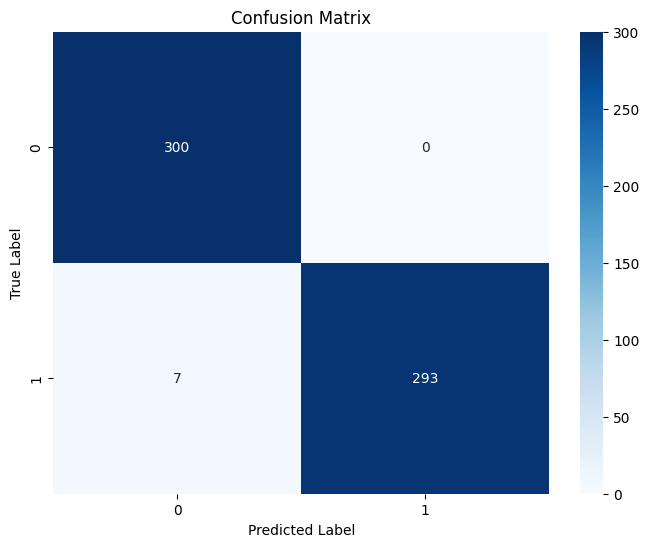

In [38]:
# Get the predicted probabilities from the model
predictions = model.predict(X_val_prep)
predictions = [1 if x > 0.5 else 0 for x in predictions]

# Calculate accuracy
accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

# Compute confusion matrix
confusion_mtx = confusion_matrix(y_val, predictions)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

19/19 [==============================] - 2s 101ms/step
Val Accuracy = 0.95


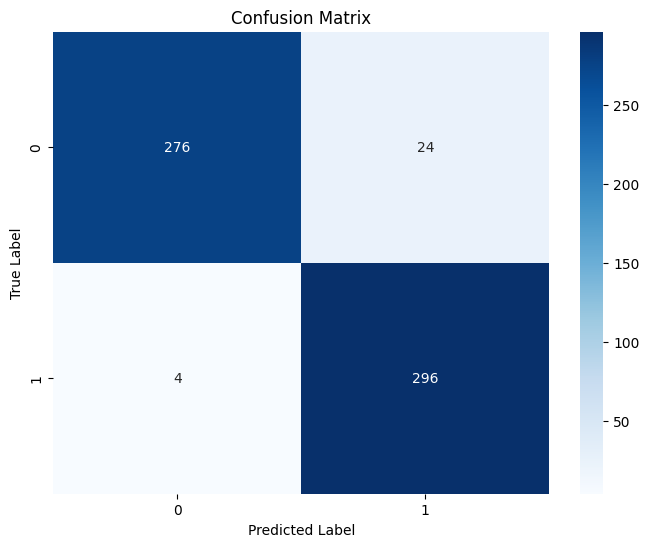

In [39]:
# Get the predicted probabilities from the model
predictions = model.predict(X_test_prep)
predictions = [1 if x > 0.5 else 0 for x in predictions]

# Calculate accuracy
accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

# Compute confusion matrix
confusion_mtx = confusion_matrix(y_val, predictions)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [35]:
prob_pred = model.predict(X_test_prep)

19/19 [==============================] - 2s 103ms/step


In [36]:
from sklearn import metrics
print('Accuracy score is :', np.round(metrics.accuracy_score(y_test, predictions),4))
print('Precision score is :', np.round(metrics.precision_score(y_test, predictions, average='weighted'),4))
print('Recall score is :', np.round(metrics.recall_score(y_test, predictions, average='weighted'),4))
print('F1 Score is :', np.round(metrics.f1_score(y_test, predictions, average='weighted'),4))
print('ROC AUC Score is :', np.round(metrics.roc_auc_score(y_test, prob_pred,multi_class='ovo', average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, predictions),4))

print('\t\tClassification Report:\n', metrics.classification_report(y_test, predictions))

Accuracy score is : 0.9533
Precision score is : 0.9554
Recall score is : 0.9533
F1 Score is : 0.9533
ROC AUC Score is : 0.99
Cohen Kappa Score: 0.9067
		Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.92      0.95       300
           1       0.93      0.99      0.95       300

    accuracy                           0.95       600
   macro avg       0.96      0.95      0.95       600
weighted avg       0.96      0.95      0.95       600



In [37]:
model.save("/content/drive/MyDrive/saved model/ResNet50.h5")